In [51]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
from preprocessing_tools.node_id_generation import generate_node_ids
import seaborn as sns
from preprocessing_tools.feature_engineering.general import intersection_length
from plotting_tools import GroupedBarPlot
from preprocessing_tools.loading_pipeline.utils import JsonLoadingPipeLine, unpack_list_of_dicts_column
from preprocessing_tools.feature_engineering.language.binary_features import is_required_language_missing

# Table of contents
1. [Load Data](#data_loading)
2. [Data Normalization](#data_normalization)
3. [Explore features](#feature_exploration)
- Categorical features
    * [Seniority](#seniority)
    * [Roles](#roles)
    * [Degree](#degrees)
    * [Language](#language)
- Numerical features
    * [Salary](#salary)
4. [Explore labels](#labels)
5. [Explore graph](#graph)

- **talent**: profile information of the talent (detailed description below).
- **job**: profile information of the job (detailed description below).
- **label**: `true` if talent and job _**match**_, else `false`.

**Talent**: 

| Field name         |    Type    |                       Description                       |
| :----------------- | :--------: | :-----------------------------------------------------: |
| degree             |    str     |              Highest degree of the talent               |
| job_roles          | list[str]  |          Job roles the talent is interested in          |
| languages          | list[dict] | Languages the talent speaks with their respective level |
| salary_expectation |    int     |  Salary the talent expects a potential new job to pay   |
| seniority          |    str     |                 Seniority of the talent                 |

**Job**:

| Field name  |    Type    |               Description               |
| :---------- | :--------: | :-------------------------------------: |
| job_roles   | list[str]  |    Applicable job roles for the job     |
| languages   | list[dict] |    Language requirements of the job     |
| max_salary  |    int     |   Maximum salary the job is offering    |
| min_degree  |    str     |  Minimum degree a talent needs to have  |
| seniorities | list[str]  | Seniorities talents are allowed to have |

In [2]:
raw_data_path = Path("./data/raw_data.json")

<a id="data_loading"></a>
## Load data

In [3]:
data_loader = JsonLoadingPipeLine(['talent', 'job', 'label'])
raw_talent, raw_job, label = data_loader(raw_data_path)

In [4]:
raw_talent = pd.json_normalize(raw_talent)
raw_job = pd.json_normalize(raw_job)

##### Check for missing values

In [5]:
raw_talent.isna().sum()

languages             0
job_roles             0
seniority             0
salary_expectation    0
degree                0
dtype: int64

In [6]:
raw_job.isna().sum()

languages      0
job_roles      0
seniorities    0
max_salary     0
min_degree     0
dtype: int64

<a id="data_normalization"></a>
### Do some normalization on the data

In [7]:
raw_job.seniorities = raw_job.seniorities.apply(sorted)
raw_job.job_roles = raw_job.job_roles.apply(sorted)

raw_job.languages = raw_job.languages.apply(lambda x: sorted(x, key = lambda y: y['title']))
raw_talent.languages = raw_talent.languages.apply(lambda x: sorted(x, key = lambda y: y['title']))

raw_talent.job_roles = raw_talent.job_roles.apply(sorted)

In [8]:
raw_job.dtypes

languages      object
job_roles      object
seniorities    object
max_salary      int64
min_degree     object
dtype: object

In [9]:
raw_job = unpack_list_of_dicts_column(raw_job, 'languages', suffix='languages')
raw_talent = unpack_list_of_dicts_column(raw_talent, 'languages', suffix='languages')

<a id="feature_exploration"></a>
## Explore features

<a id="seniority"></a>
### Explore Seniority levels
There is a known hierarchy of the seniority levels, so it might be useful to encode it for the baselines instead of using only one-hot vectors.
Question remains: what is none for a seniority? (May possible need some additional processing)

In [10]:
job_seniorities_counts = raw_job.seniorities.explode().value_counts()
talent_seniorities_counts = raw_talent.seniority.value_counts()

###### check if all seniorities are present in both sets

In [11]:
job_seniorities_counts.index.symmetric_difference(talent_seniorities_counts.index)

Index([], dtype='object')

In [12]:
seniority_order = ['none', 'junior', 'midlevel', 'senior']
job_seniorities_counts = job_seniorities_counts.loc[seniority_order]
talent_seniorities_counts = talent_seniorities_counts.loc[seniority_order]

/home/lexoro/recommendersystemtask/plotting_tools/grouped_bar_plot.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return self._grouped_bar_plot(*value_arrays_for_annotations).show()


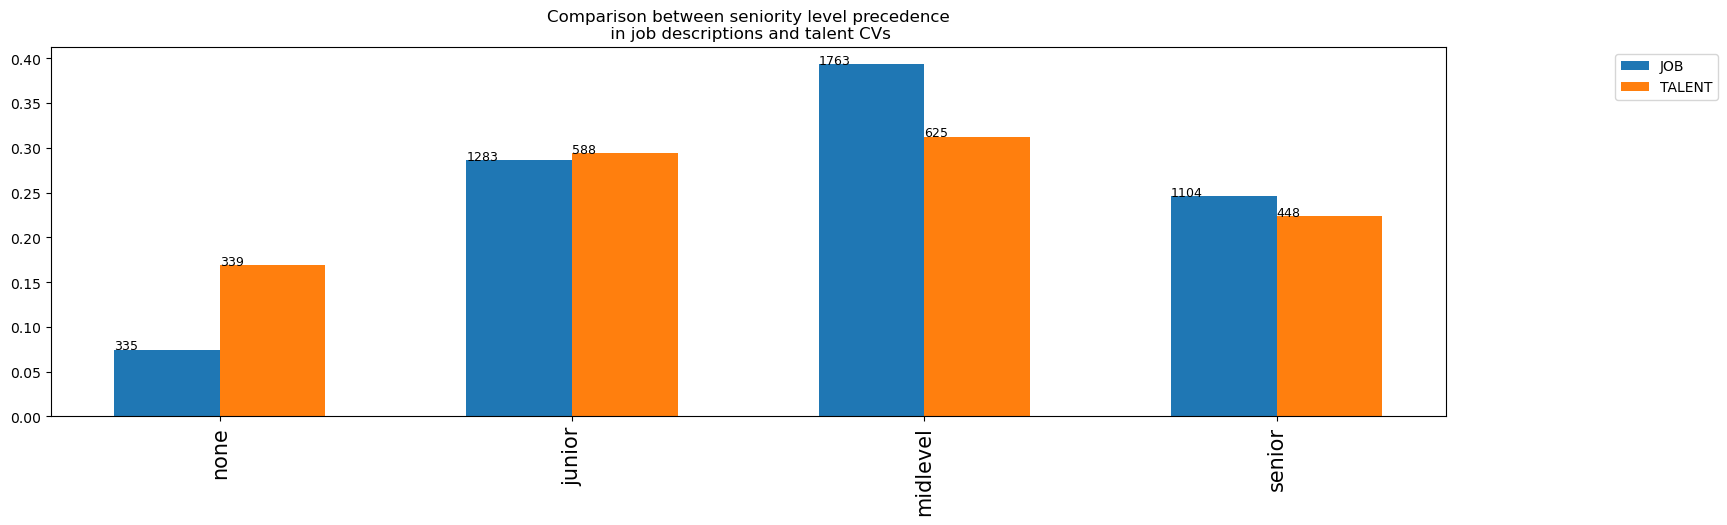

In [13]:
GroupedBarPlot(job_seniorities_counts/job_seniorities_counts.sum(),
                   talent_seniorities_counts/talent_seniorities_counts.sum(), 
                   bar_width=0.3, 
                   title = "Comparison between seniority level precedence\n in job descriptions and talent CVs",
                   legend_labels = ["JOB", "TALENT"]).show(job_seniorities_counts, talent_seniorities_counts)

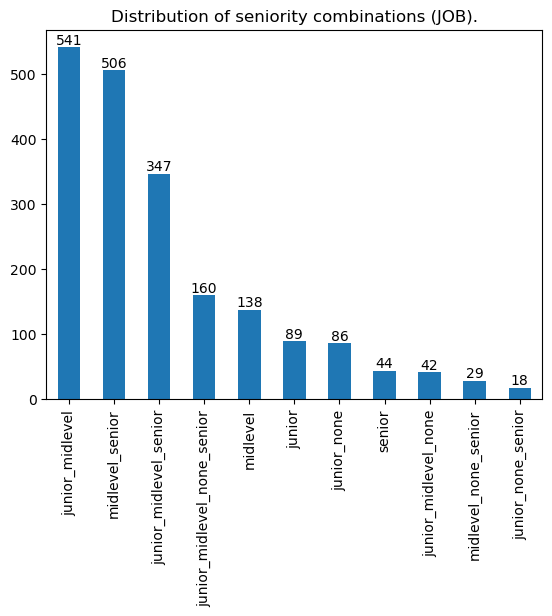

In [14]:
ax = raw_job.seniorities.apply(lambda x: "_".join(x)).value_counts().plot.bar()
_ = ax.bar_label(ax.containers[0])
_ = ax.set_title("Distribution of seniority combinations (JOB).")

<a id="roles"></a>
### Explore job roles

In [15]:
job_roles_counts = raw_job.job_roles.explode().value_counts()
talent_roles_counts = raw_talent.job_roles.explode().value_counts()

In [16]:
# roles present in jobs, but not present in talents
job_roles_counts.index.difference(talent_roles_counts.index)

Index([], dtype='object')

In [17]:
# roles present in talents, but not present in jobs
missing_roles_in_jobs = talent_roles_counts.index.difference(job_roles_counts.index)

There are roles which are ***not*** present in the job offers:

In [18]:
talent_roles_counts.loc[missing_roles_in_jobs]

1st-2nd-3rd-level-support          80
cmo-or-head-of-marketing           49
copywriter                         64
cpo-or-head-of-product             57
cso-or-head-of-sales               76
cto                                69
database-administrator             72
graphic-designer                   48
head-of-data                       49
machine-learning-engineer         114
marketing-team-lead                62
network-engineer                   48
product-manager                   153
sales-engineer                    101
sales-team-lead                   124
seo-sea-manager                    48
site-reliability-engineer          64
social-media-marketing-manager     95
ui-ux-designer                    107
ux-researcher                      59
Name: job_roles, dtype: int64

In [19]:
adjusted_job_roles_counts = pd.concat((job_roles_counts, pd.Series(np.zeros(len(missing_roles_in_jobs), dtype = int), index = missing_roles_in_jobs)))

/home/lexoro/recommendersystemtask/plotting_tools/grouped_bar_plot.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return self._grouped_bar_plot(*value_arrays_for_annotations).show()


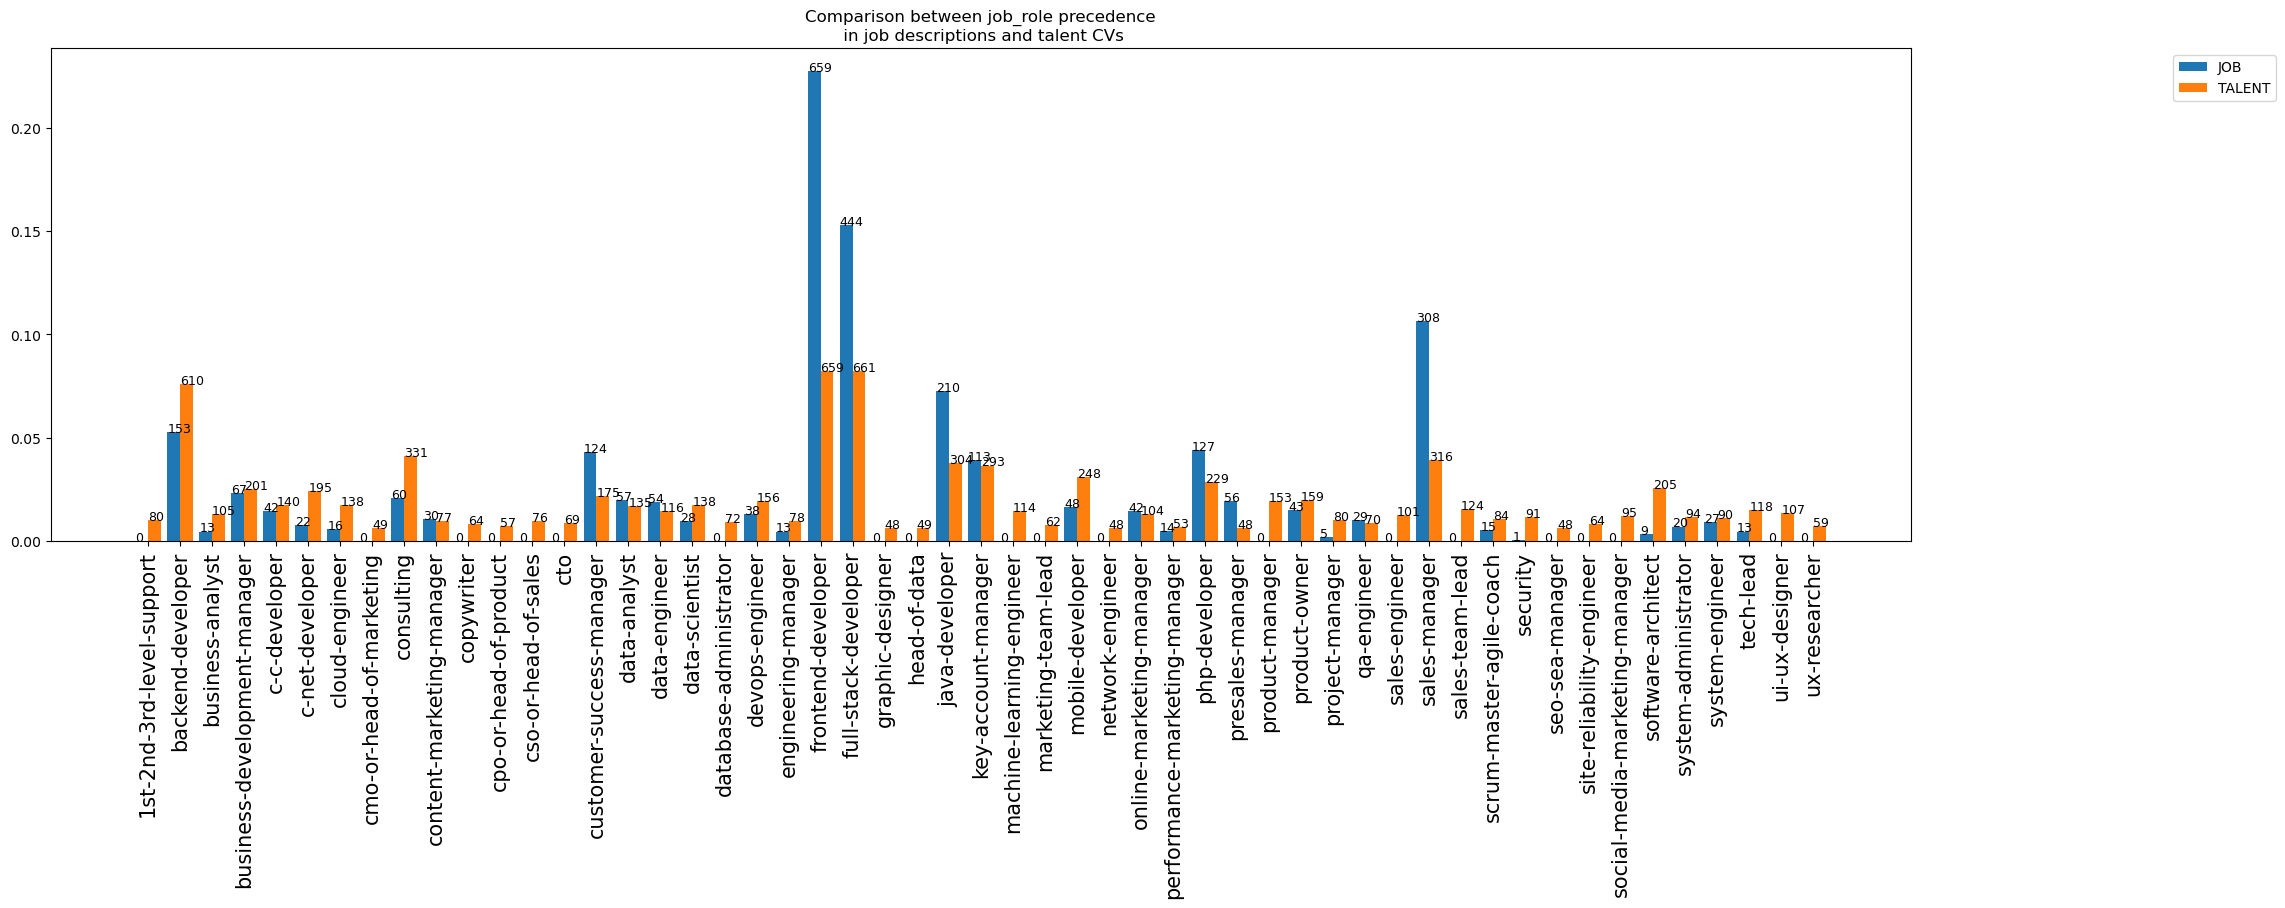

In [20]:
adjusted_talent_roles_counts = talent_roles_counts.sort_index()
adjusted_job_roles_counts = adjusted_job_roles_counts.sort_index()

GroupedBarPlot(adjusted_job_roles_counts/adjusted_job_roles_counts.sum(),
               adjusted_talent_roles_counts/adjusted_talent_roles_counts.sum(),
                   bar_width=0.4, 
                   title = "Comparison between job_role precedence\n in job descriptions and talent CVs",
                   legend_labels = ["JOB", "TALENT"]).show(adjusted_job_roles_counts, adjusted_talent_roles_counts)

In [21]:
missing_roles_dict = {i: True for i in missing_roles_in_jobs}

In [22]:
role_df = pd.concat((raw_talent.job_roles.rename("talent_job_roles"), raw_job.job_roles, label), axis = 1)

In [23]:
role_df.loc[:, "intersection"] = role_df[['talent_job_roles', "job_roles"]].apply(lambda x: intersection_length(*x), axis = 1)

Text(0.5, 1.0, 'Distribution of intersection of job description roles\n and talent roles')

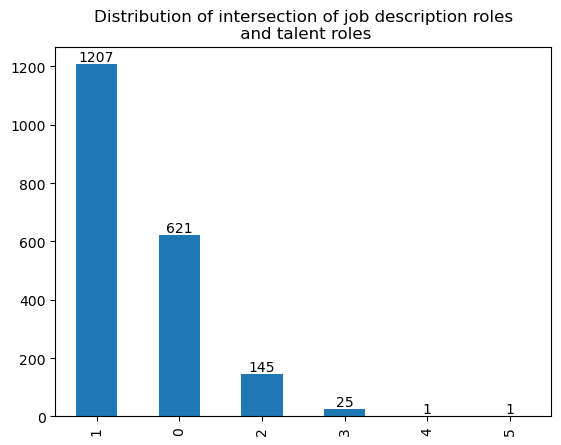

In [24]:
axis = role_df.intersection.value_counts().plot.bar()
_ = axis.bar_label(axis.containers[0])
plt.title("Distribution of intersection of job description roles\n and talent roles")

In [25]:
# if p(False|0) = 1 on this data
role_df.groupby(["label", "intersection"]).size()

label  intersection
False  0               621
       1               335
       2                36
       3                 6
       4                 1
       5                 1
True   1               872
       2               109
       3                19
dtype: int64

<a id="language"></a>
### Explore Language
Again we have a hierarchy in the ratings. The good thing is the language levels from A1 to C2 are already comparable.

In [26]:
job_languages = pd.json_normalize(raw_job.languages.explode())
job_languages.groupby(["title",'rating']).size()

title    rating
English  B1         109
         B2         750
         C1         437
         C2          22
German   B1         132
         B2         138
         C1        1328
         C2         402
dtype: int64

the must have feature binary.

In [27]:
job_languages.must_have.unique()

array([ True, False])

In [28]:
talent_languages = pd.json_normalize(raw_talent.languages.explode())
talent_languages.groupby(["title"]).size()

title
Albanian         7
Arabic          87
Armenian         1
Bengalese        1
Bulgarian        4
Chinese         28
Croatian        21
Czech            5
Danish           5
Dutch           31
English       1997
Finnish          1
French         416
German        1996
Greek           10
Hebrew           4
Hindi           15
Hungarian        8
Italian         67
Japanese        26
Korean           6
Latvian          1
Macedonian       1
Norwegian        2
Persian         27
Polish          49
Portuguese      31
Romanian         8
Russian        132
Serbian         10
Slovak           1
Spanish        313
Swedish         21
Tamil            3
Turkish        106
dtype: int64

In [29]:
languages_concat = pd.concat((raw_talent[['rating_languages', "title_languages"]].rename(lambda x: "talent"+"_"+x, axis = 'columns'),
           raw_job[['rating_languages', "title_languages", 'must_have_languages']], 
           label), axis = 1)

The number of requirement specifications and languages in the requirements is always equal in the dataset!

In [49]:
sum(languages_concat.title_languages.str.len()!=languages_concat.must_have_languages.str.len())

0

In [31]:
languages_concat.loc[:, 'intersection'] = languages_concat[['talent_title_languages', "title_languages"]].apply(lambda x: intersection_length(*x), axis = 1)

In [32]:
languages_concat.groupby(['label', 'intersection']).size()

label  intersection
False  1               354
       2               646
True   1               332
       2               668
dtype: int64

In [53]:
languages_concat.loc[:, "is_required_lang_missing"] = languages_concat[["title_languages", "talent_title_languages", "must_have_languages"]]\
                                                        .apply(lambda x: is_required_language_missing(*x), axis = 1)

In [57]:
languages_concat.loc[:, "is_required_lang_missing"].sum()

0

<a id="degrees"></a>
### Explore degrees
There is a known hierarchy of the deegrees, so it might be useful to encode it for the baselines instead of using only one-hot vectors.

In [33]:
degree_order = ["none", "bachelor", "apprenticeship", "master", "doctorate"]
job_seniorities_counts = raw_job.min_degree.value_counts().loc[degree_order]
talent_degree_counts = raw_talent.degree.value_counts().loc[degree_order]

/home/lexoro/recommendersystemtask/plotting_tools/grouped_bar_plot.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return self._grouped_bar_plot(*value_arrays_for_annotations).show()


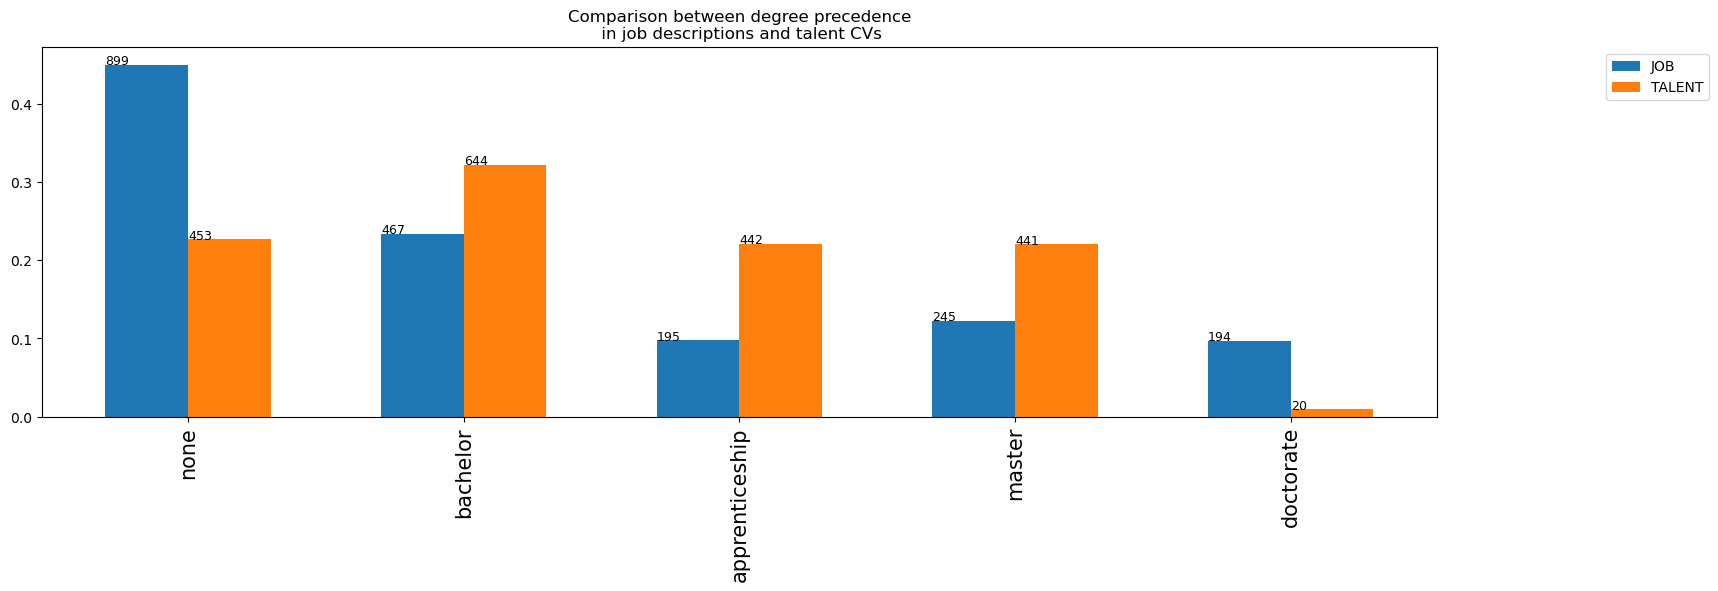

In [34]:
GroupedBarPlot(job_seniorities_counts/job_seniorities_counts.sum(),
                   talent_degree_counts/talent_degree_counts.sum(), 
                   bar_width=0.3, 
                   title = "Comparison between degree precedence\n in job descriptions and talent CVs",
                   legend_labels = ["JOB", "TALENT"]).show(job_seniorities_counts, talent_degree_counts)

## Explore numerical features

<a id="salary"></a>
### Salary

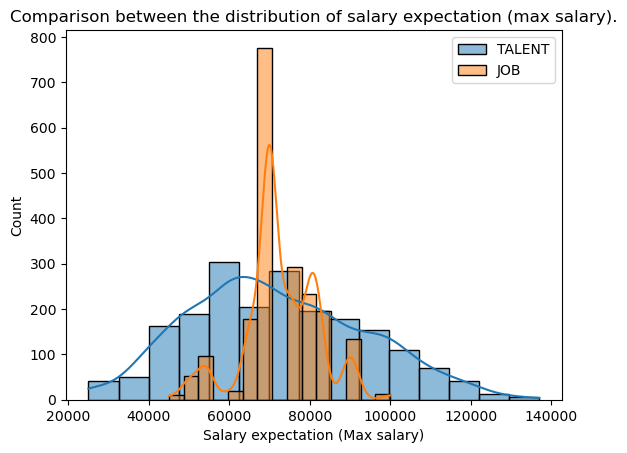

In [35]:
_ = sns.histplot(raw_talent.salary_expectation, bins = 15, kde=True, label = 'TALENT')
_ = sns.histplot(raw_job.max_salary, bins = 15, kde=True, label = "JOB")
_ = plt.legend()
_ = plt.xlabel("Salary expectation (Max salary)")
_ = plt.title("Comparison between the distribution of salary expectation (max salary).")

In [36]:
raw_talent.groupby("seniority").agg(mean = ("salary_expectation", np.mean), 
                                    std = ("salary_expectation", lambda x: np.std(x)/np.mean(x)),
                                    minimum = ("salary_expectation", np.min))

,mean,std,minimum
seniority,,,
junior,64713.003401,0.366122,25000
midlevel,70141.212800,0.266032,25000
none,80566.345133,0.296522,25000
senior,76384.562500,0.237984,25000


### Analyze degree encoding

In [37]:
raw_talent.loc[:, "encoded_degree"] = raw_talent.degree.replace({lvl: i for i, lvl in enumerate(degree_order)})
raw_job.loc[:, "encoded_degree"] = raw_job.min_degree.replace({lvl: i for i, lvl in enumerate(degree_order)})

In [39]:
degree_dataset = pd.concat((raw_talent.encoded_degree.rename("talent_degree"), 
           raw_job.encoded_degree.rename("job_degree"),
           label), axis = 1)

In [40]:
degree_dataset.loc[:, "diff"] = degree_dataset.talent_degree - degree_dataset.job_degree

In [41]:
# p(False|negative_diff) is visibly extremely high -> this might be a very useful feature
degree_dataset.groupby(['label', 'diff']).size()

label  diff
False  -4       71
       -3      140
       -2      188
       -1      151
        0      136
        1      137
        2      111
        3       61
        4        5
True   -1       32
        0      291
        1      248
        2      276
        3      148
        4        5
dtype: int64

<a id="labels"></a>
## Explore Labels


In [62]:
# exactly balanced labels
label.value_counts()

True     1000
False    1000
Name: label, dtype: int64

<a id="graph"></a>
## Assign IDs to jobs and talents to possibly build a graph
There are drastically more talents than unique job offers. It would have been nice to know how many open positions there are for a job description.

In [42]:
raw_job.loc[:, "job_id"] = generate_node_ids(raw_job)
raw_talent.loc[:, "talent_id"] = generate_node_ids(raw_talent)

In [43]:
raw_job.job_id.nunique()

123

In [44]:
raw_talent.talent_id.nunique()

1946

Text(0.5, 1.0, 'Distribution of probability of succes per job.')

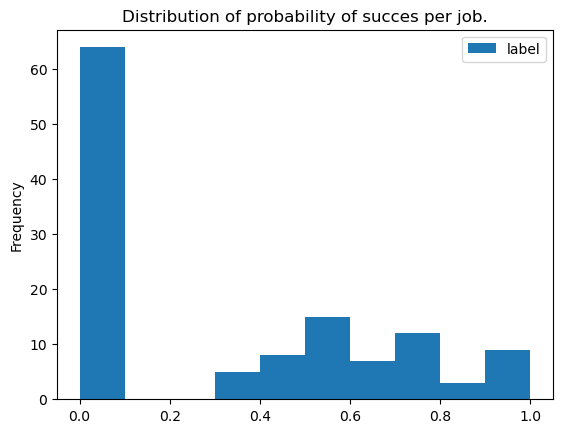

In [100]:
pd.concat((raw_job['job_id'], label), axis = 1)\
            .groupby(["job_id"]).agg({'label': lambda x: sum(x)/len(x)}).plot.hist()
plt.title("Distribution of probability of succes per job.")